In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as _sum

from glob import glob 
from functools import reduce 

# Crear la sesión de Spark
spark = SparkSession.builder.appName("Ejercicio5").getOrCreate()

In [7]:
archivos = glob('txn*.csv')

In [11]:
l = []
for arch in archivos:
    df = spark.read.csv(arch,header=True,inferSchema=True) 
    l.append(df)

In [13]:
df = reduce(lambda x,y:x.union(y),l)

In [16]:
df.printSchema()

root
 |-- User: integer (nullable = true)
 |-- Card: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Amount: string (nullable = true)
 |-- Use Chip: string (nullable = true)
 |-- Merchant Name: long (nullable = true)
 |-- Merchant City: string (nullable = true)
 |-- Merchant State: string (nullable = true)
 |-- Zip: double (nullable = true)
 |-- MCC: integer (nullable = true)
 |-- Errors?: string (nullable = true)
 |-- Is Fraud?: string (nullable = true)



In [20]:
df.groupby('Is Fraud?').count().show()

+---------+--------+
|Is Fraud?|   count|
+---------+--------+
|       No|24357143|
|      Yes|   29757|
+---------+--------+



In [21]:
df.createOrReplaceTempView('tabla')

In [23]:
query = """
select `Is Fraud?`,count(*) as casos from tabla
group by all
"""

In [25]:
spark.sql(query).show()

+---------+--------+
|Is Fraud?|   casos|
+---------+--------+
|       No|24357143|
|      Yes|   29757|
+---------+--------+



In [26]:
df = spark.read.csv('txn*.csv',inferSchema=True,header=True)

In [27]:
df.createOrReplaceTempView('tabla')

In [28]:
spark.sql(query).show()

+---------+--------+
|Is Fraud?|   casos|
+---------+--------+
|       No|24357143|
|      Yes|   29757|
+---------+--------+



In [37]:
df = df.coalesce(1)

In [38]:
df.write.parquet('regreso/txn')

In [34]:
spark.read.parquet('regreso/txn').count()

24386900

In [13]:
df = spark.read.parquet('work/regreso/txn')

In [14]:
df = df.select('Year','Month','Amount','Merchant State')

In [15]:
d = dict(zip(['Year','Month','Amount','Merchant State'],['year','month','amt','state']))

In [16]:
for viejo,nuevo in d.items():
    df = df.withColumnRenamed(viejo,nuevo)
                                               

In [17]:
from pyspark.sql import functions as F

In [18]:
func = F.udf(lambda x:x.replace('$',''))

In [19]:
df = df.withColumn('amt', func(F.col('amt')).cast('double'))

In [20]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- amt: double (nullable = true)
 |-- state: string (nullable = true)



In [22]:
df.createOrReplaceTempView('tabla')
cat = spark.sql('select distinct state from tabla order by state').toPandas()

In [ ]:
us_states = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

In [34]:
df = df.filter(F.col('state').isin(us_states))

In [35]:
df = df.groupBy('year','month','state').agg(_sum('amt').alias('total'))

In [36]:
df.show()

+----+-----+-----+------------------+
|year|month|state|             total|
+----+-----+-----+------------------+
|2013|    7|   AR| 40618.37999999998|
|2014|    3|   CA|         620928.79|
|2017|    9|   AL| 69366.87999999996|
|2012|    6|   NJ|152557.05000000022|
|2010|    4|   VA|111710.75000000026|
|2016|    6|   NY|388031.58999999997|
|2019|    2|   NY|357064.29000000015|
|2014|    8|   NY|         414716.19|
|2018|    4|   NY| 361853.8399999999|
|2019|    9|   IL|197710.14999999976|
|2005|    5|   NV|20175.390000000007|
|2016|   12|   MA|123252.89999999994|
|2018|    4|   MI|146647.91999999998|
|2000|    6|   MI|14700.740000000002|
|2004|    2|   IN| 48063.84000000002|
|2006|    8|   MO| 36083.17999999999|
|2009|    7|   LA| 65411.71999999999|
|2012|    4|   NE| 23357.51999999999|
|1997|   12|   FL|          19720.99|
|1998|    1|   FL|19237.949999999997|
+----+-----+-----+------------------+
only showing top 20 rows



In [37]:
pivot_df = df.groupBy('year', 'month').pivot('state').sum('total')
pivot_df.show()

+----+-----+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|year|month|                AK|      

In [39]:
st = pivot_df.toPandas().fillna(0).sort_values(by=['year','month']).reset_index(drop=True)

<Axes: >

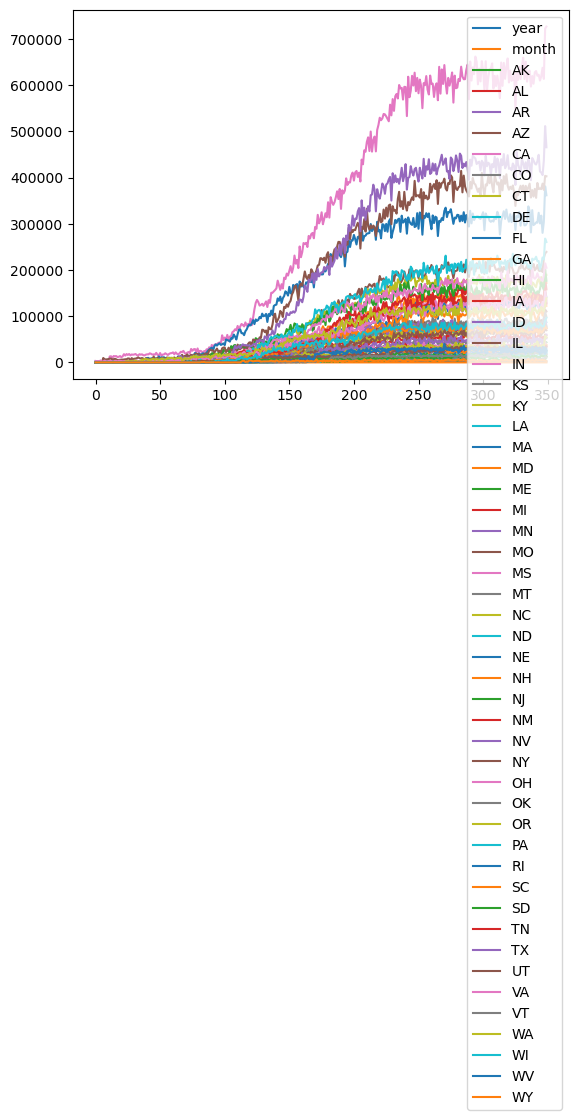

In [41]:
st.plot()